In [1]:
from __future__ import division, print_function
from matplotlib import pyplot as plt
import seaborn as sns

import pickle
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from scipy.sparse import hstack
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression

In [2]:
audit = pd.read_csv('audit_risk.csv', index_col=None) 
trial = pd.read_csv('trial.csv', index_col=None)

audit.columns = [c.upper() for c in audit.columns]
trial.columns = [c.upper() for c in trial.columns]
audit = audit.loc[:, ~audit.columns.duplicated()]

score_cols_audit = [c for c in audit.columns if 'SCORE' in c]
score_cols_trial = [c for c in trial.columns if 'SCORE' in c]

audit[score_cols_audit] = audit[score_cols_audit].apply(pd.to_numeric, errors='coerce')
trial[score_cols_trial] = trial[score_cols_trial].apply(pd.to_numeric, errors='coerce')

audit = audit.sort_values(by=score_cols_audit[0])

print(audit.shape)
print(trial.shape)
audit.head()

(776, 26)
(776, 18)


,SECTOR_SCORE,LOCATION_ID,PARA_A,SCORE_A,RISK_A,PARA_B,SCORE_B,RISK_B,TOTAL,NUMBERS,...,PROB,RISK_E,HISTORY,RISK_F,SCORE,INHERENT_RISK,CONTROL_RISK,DETECTION_RISK,AUDIT_RISK,RISK
428,1.85,12,0.60,0.2,0.120,1.14,0.4,0.456,1.74,5.0,...,0.2,0.4,0,0.0,2.6,2.062,0.4,0.5,0.4124,0
416,1.85,19,2.81,0.6,1.686,0.11,0.2,0.022,2.92,5.0,...,0.2,1.2,0,0.0,3.2,15.578,1.2,0.5,9.3468,1
417,1.85,19,5.87,0.6,3.522,0.00,0.2,0.000,5.87,5.0,...,0.2,1.2,0,0.0,2.8,5.810,1.2,0.5,3.4860,1
418,1.85,19,1.75,0.4,0.700,0.00,0.2,0.000,1.75,5.0,...,0.2,1.2,0,0.0,2.6,2.970,1.2,0.5,1.7820,1
419,1.85,19,2.05,0.6,1.230,0.00,0.2,0.000,2.05,5.0,...,0.2,1.2,0,0.0,2.8,4.136,1.2,0.5,2.4816,1


In [4]:
common_sectors = [c for c in audit.columns if c in trial.columns]

for col in common_sectors:
    audit[col] = pd.to_numeric(audit[col], errors='coerce').fillna(0).astype(int)
    trial[col] = pd.to_numeric(trial[col], errors='coerce').fillna(0).astype(int)

sector_dict = {i: s for i, s in enumerate(common_sectors, 1)}

sectors_df = pd.DataFrame(
    list(sector_dict.values()),
    index=list(sector_dict.keys()),
    columns=['sector']
)

print(f'Всего секторов: {sectors_df.shape[0]}')
sectors_df.head()

Всего секторов: 12


,sector
1,SECTOR_SCORE
2,LOCATION_ID
3,PARA_A
4,SCORE_A
5,PARA_B


In [5]:
top_sectors = (
    pd.Series(audit[common_sectors].fillna(0).values.flatten())
      .value_counts()
      .sort_values(ascending=False)
      .head(5)
)

print('Сектора по встречаемости:')
print(top_sectors)

Сектора по встречаемости:
0    4456
1     890
2     880
5     871
3     411
Name: count, dtype: int64


In [6]:
time_df = pd.DataFrame(index=audit.index)
time_df['audit_risk'] = audit['AUDIT_RISK'] 

time_df.head()

,audit_risk
428,0.4124
416,9.3468
417,3.4860
418,1.7820
419,2.4816


In [18]:
y_train = audit['AUDIT_RISK']

full_df = pd.concat(
    [audit.drop('AUDIT_RISK', axis=1), trial],
    ignore_index=True
)

idx_split = audit.shape[0]

print('y_train', y_train.shape)
print('audit', audit.shape)
print('full_df', full_df.shape)

y_train (776,)
audit (776, 26)
full_df (1552, 31)


In [42]:
full_sectors = full_df[numeric_cols].fillna(0)

sectors_flatten = full_sectors.values.flatten()
data = sectors_flatten.astype(float)
row_ind = np.repeat(np.arange(full_sectors.shape[0]), full_sectors.shape[1])
col_ind = np.tile(np.arange(full_sectors.shape[1]), full_sectors.shape[0])

full_sectors_sparse = csr_matrix(
    (data, (row_ind, col_ind)),
    shape=full_sectors.shape
)
full_sectors.head()

,SECTOR_SCORE,LOCATION_ID,PARA_A,SCORE_A,RISK_A,PARA_B,SCORE_B,RISK_B,TOTAL,NUMBERS,...,INHERENT_RISK,CONTROL_RISK,DETECTION_RISK,RISK,MARKS,MONEY_MARKS,DISTRICT,LOSS,LOSS_SCORE,HISTORY_SCORE
0,1,12,0,0,0.120,1,0,0.456,1,5,...,2.062,0.4,0.5,0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,19,2,0,1.686,0,0,0.022,2,5,...,15.578,1.2,0.5,1,0.0,0.0,0.0,0.0,0.0,0.0
2,1,19,5,0,3.522,0,0,0.000,5,5,...,5.810,1.2,0.5,1,0.0,0.0,0.0,0.0,0.0,0.0
3,1,19,1,0,0.700,0,0,0.000,1,5,...,2.970,1.2,0.5,1,0.0,0.0,0.0,0.0,0.0,0.0
4,1,19,2,0,1.230,0,0,0.000,2,5,...,4.136,1.2,0.5,1,0.0,0.0,0.0,0.0,0.0,0.0


In [43]:
def get_auc_lr_valid(X, y, C=1.0, seed=17, ratio=0.9):
    idx = int(round(X.shape[0] * ratio))
    lr = LogisticRegression(
        C=C,
        random_state=seed,
        n_jobs=-1,
        max_iter=2000
    ).fit(X[:idx, :], y[:idx])
    y_pred = lr.predict_proba(X[idx:, :])[:, 1]
    score = roc_auc_score(y[idx:], y_pred)
    return score

X_train = full_sectors_sparse[:idx_split, :]
y_train_bin = (y_train > 0.5).astype(int)

np.random.seed(17)
random_feat = np.random.rand(X_train.shape[0], 1)

X_train_aug = hstack([
    X_train,
    csr_matrix(random_feat)
])

print(get_auc_lr_valid(X_train_aug, y_train_bin))

0.9910714285714286


In [44]:
print('{0} elements * {1} bytes = {2} bytes'.format(
    full_sectors_sparse.count_nonzero(),
    4,
    full_sectors_sparse.count_nonzero() * 4
))

23945 elements * 4 bytes = 95780 bytes


In [45]:
def get_auc_lr_valid(X, y, C=1.0, seed=17, ratio=0.9):
    idx = int(round(X.shape[0] * ratio))
    lr = LogisticRegression(
        C=C,
        random_state=seed,
        n_jobs=-1,
        max_iter=2000
    ).fit(X[:idx, :], y[:idx])
    y_pred = lr.predict_proba(X[idx:, :])[:, 1]
    score = roc_auc_score(y[idx:], y_pred)
    return score


X_train = full_sectors_sparse[:idx_split, :]
y_train_bin = (y_train > 0.5).astype(int)

np.random.seed(17)
random_feat = np.random.rand(X_train.shape[0], 1)

X_train_aug = hstack([
    X_train,
    csr_matrix(random_feat)
])

print(get_auc_lr_valid(X_train_aug, y_train_bin))

0.9910714285714286


In [46]:
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(
        predicted_labels,
        index=np.arange(1, predicted_labels.shape[0] + 1),
        columns=[target]
    )
    predicted_df.to_csv(out_file, index_label=index_label)


lr = LogisticRegression(C=1.0, random_state=17, n_jobs=-1, max_iter=2000)
lr.fit(X_train, y_train_bin)

X_test = full_sectors_sparse[idx_split:, :]
y_test = lr.predict_proba(X_test)[:, 1]

write_to_submission_file(y_test, 'baseline_sectors.csv')

In [47]:
full_new_feat = pd.DataFrame(index=full_df.index)

score_cols = [c for c in full_df.columns if 'SCORE' in c]
full_new_feat['score_sum'] = full_df[score_cols].sum(axis=1)
full_new_feat['score_mean'] = full_df[score_cols].mean(axis=1)

In [48]:
alphas = np.logspace(-3, 1, 10)
scores = []

idx = int(round(X_train.shape[0] * 0.9))

for a in alphas:
    C = 1 / a

    model = LogisticRegression(
        C=C,
        random_state=17,
        max_iter=2000
    )

    model.fit(X_train[:idx, :], y_train_bin[:idx])
    y_pred = model.predict(X_train[idx:, :])

    mse = mean_squared_error(y_train_bin[idx:], y_pred)
    scores.append(mse)

    print(a, "->", mse)

0.001 -> 0.02564102564102564
0.0027825594022071257 -> 0.02564102564102564
0.007742636826811269 -> 0.02564102564102564
0.021544346900318832 -> 0.02564102564102564
0.05994842503189409 -> 0.02564102564102564
0.1668100537200059 -> 0.02564102564102564
0.46415888336127775 -> 0.02564102564102564
1.2915496650148828 -> 0.02564102564102564
3.593813663804626 -> 0.02564102564102564
10.0 -> 0.1282051282051282


In [49]:
Cs = np.logspace(-3, 1, 10)
scores = []

for C in Cs:
    sc = get_auc_lr_valid(X_train_aug, y_train_bin, C=C)
    scores.append(sc)
    print(C, '->', sc)

0.001 -> 0.922077922077922
0.0027825594022071257 -> 0.963474025974026
0.007742636826811269 -> 0.9748376623376624
0.021544346900318832 -> 0.9813311688311688
0.05994842503189409 -> 0.984577922077922
0.1668100537200059 -> 0.9878246753246753
0.46415888336127775 -> 0.989448051948052
1.2915496650148828 -> 0.9910714285714286
3.593813663804626 -> 0.9935064935064934
10.0 -> 0.9959415584415584


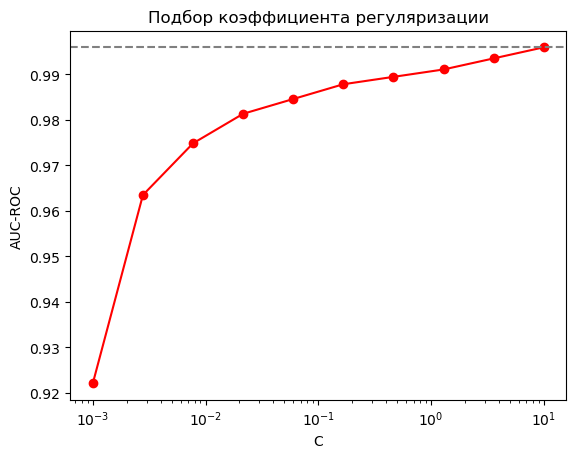

In [50]:
plt.plot(Cs, scores, 'ro-')
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('AUC-ROC')
plt.title('Подбор коэффициента регуляризации')
plt.axhline(y=max(scores), color='gray', linestyle='dashed')
plt.show()